In [ ]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/aiken516/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

import time

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 382 (delta 21), reused 24 (delta 9), pack-reused 340
Receiving objects: 100% (382/382), 45.35 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (219/219), done.
renamed 'one-pixel-attack-keras/1_one_pixel_attack_cifar10.ipynb' -> './1_one_pixel_attack_cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './LIC

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

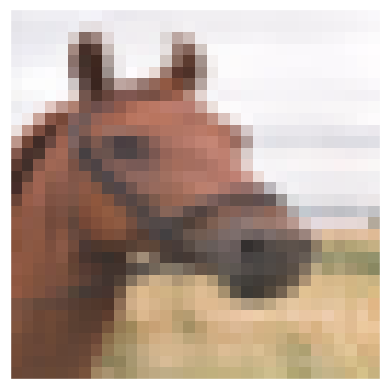

In [ ]:
image_id = 99 # Image index in the test set
helper.plot_image(x_test[image_id])

In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    print(type(xs))
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

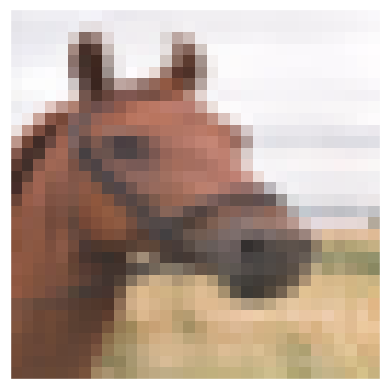

[199 178 127]


In [ ]:
image_id = 99 # Image index in the test set
helper.plot_image(x_test[image_id])
horse_img=x_test[image_id]
print(horse_img[31,31])

<class 'numpy.ndarray'>


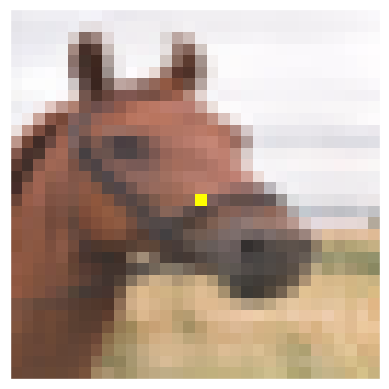

In [ ]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

In [ ]:
# Should output /device:GPU:0
# K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

tf.test.gpu_device_name()

''

In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

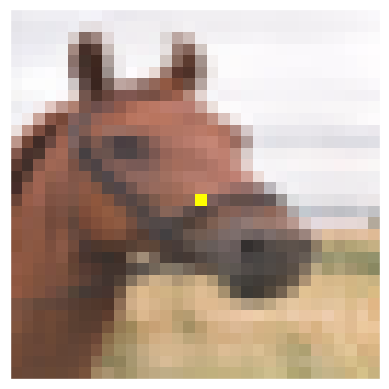

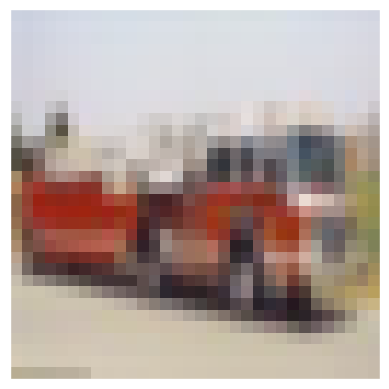

In [ ]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)
helper.plot_image(x_test[8000])

In [ ]:
# Should output /device:GPU:0
# K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

tf.test.gpu_device_name()

''

In [ ]:
lenet = LeNet()
resnet = ResNet()
# densenet = DenseNet()
models = [lenet, resnet]
# models = [lenet, resnet, densenet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet


### show attacked image

In [ ]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

def show_attacked_image(image_id,x,y,rgb):
  # image_id = 16 # Image index in the test
  #pixel = np.array([16, 16,0, 255, 255]) # pixel = x,y,r,g,b
  model=resnet
  img = x_test[image_id]
  pixel=np.array([x,y,rgb[0],rgb[1],rgb[2]])
  image_perturbed = perturb_image(pixel, x_test[image_id])[0]
  # predicted_probs=model.predict_one(image_perturbed)[true_class]
  predicted_probs=model.predict_one(image_perturbed)
  print(f"confidence score:{predicted_probs}")

  true_class = y_test[image_id, 0]
  prior_confidence = model.predict_one(x_test[image_id])[true_class]

  changed_confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]
  print('Confidence in true class', class_names[true_class], 'is', changed_confidence)
  print('Prior confidence was', prior_confidence)

  helper.plot_image(image_perturbed)



1/1 [==============================] - 1s 953ms/step
confidence score:[4.7990696e-09 1.1159352e-06 6.8453437e-01 8.4441046e-05 2.4348710e-06
 3.1501180e-01 3.5779746e-04 2.1962599e-06 5.4113148e-06 3.4944219e-07]
1/1 [==============================] - 0s 33ms/step
Confidence in true class bird is 0.6845344
Prior confidence was 0.70661753


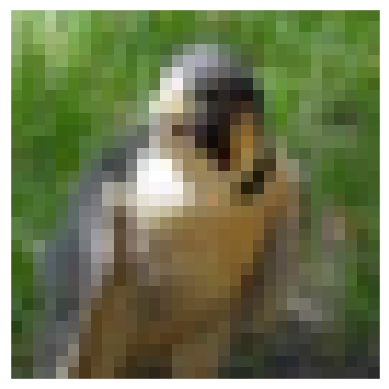

1/1 [==============================] - 0s 53ms/step
confidence score:[9.7571613e-09 2.1024821e-06 6.1816704e-01 7.8246536e-05 3.8960525e-06
 3.8067535e-01 1.0567344e-03 2.5948252e-06 1.3465019e-05 6.1241116e-07]
1/1 [==============================] - 0s 32ms/step
Confidence in true class bird is 0.61816704
Prior confidence was 0.70661753


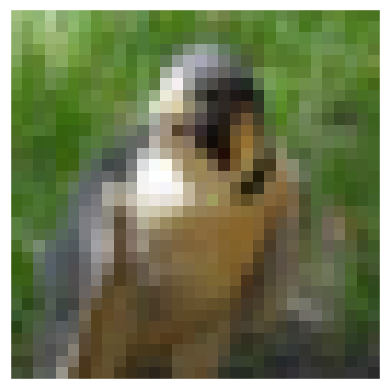

1/1 [==============================] - 0s 42ms/step
confidence score:[7.5969950e-09 1.8599910e-06 6.5741891e-01 8.7056149e-05 3.0653232e-06
 3.4175143e-01 7.2511268e-04 2.4837452e-06 9.5916821e-06 5.4228184e-07]
1/1 [==============================] - 0s 34ms/step
Confidence in true class bird is 0.6574189
Prior confidence was 0.70661753


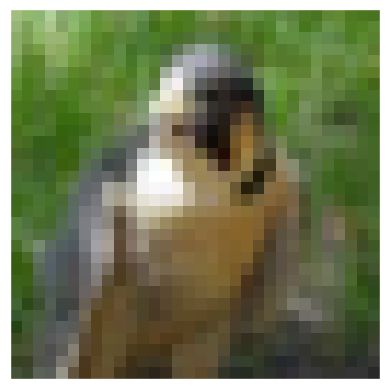

1/1 [==============================] - 0s 45ms/step
confidence score:[6.0382281e-09 1.3872021e-06 6.7657089e-01 8.4407380e-05 2.9005398e-06
 3.2285440e-01 4.7581462e-04 2.3948594e-06 7.3880710e-06 4.2028867e-07]
1/1 [==============================] - 0s 33ms/step
Confidence in true class bird is 0.6765709
Prior confidence was 0.70661753


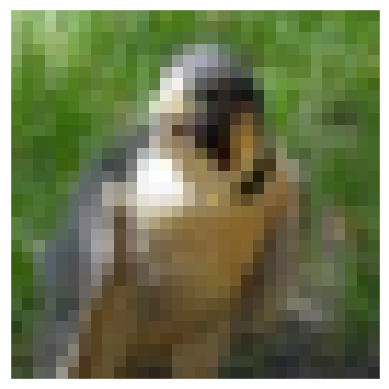

1/1 [==============================] - 0s 34ms/step
confidence score:[5.0055990e-09 1.2387997e-06 6.7754841e-01 8.0480735e-05 2.4993960e-06
 3.2199189e-01 3.6685303e-04 2.3734049e-06 5.8919632e-06 3.7847974e-07]
1/1 [==============================] - 0s 31ms/step
Confidence in true class bird is 0.6775484
Prior confidence was 0.70661753


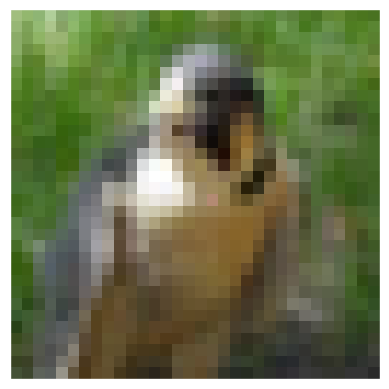

1/1 [==============================] - 0s 48ms/step
confidence score:[9.4363370e-09 2.2702127e-06 6.7540944e-01 8.2307248e-05 3.6792690e-06
 3.2355577e-01 9.2952797e-04 2.6401565e-06 1.3671471e-05 6.9119017e-07]
1/1 [==============================] - 0s 32ms/step
Confidence in true class bird is 0.67540944
Prior confidence was 0.70661753


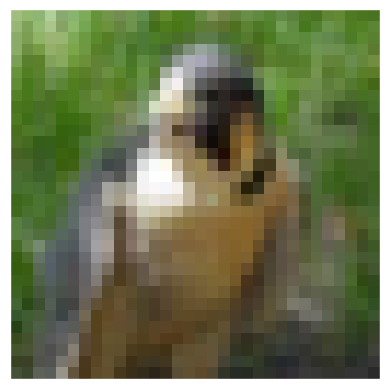

1/1 [==============================] - 0s 42ms/step
confidence score:[5.7416338e-09 1.4437094e-06 7.2581339e-01 8.4720734e-05 2.6697064e-06
 2.7365318e-01 4.3437473e-04 2.3765976e-06 7.4075256e-06 4.3839754e-07]
1/1 [==============================] - 0s 57ms/step
Confidence in true class bird is 0.7258134
Prior confidence was 0.70661753


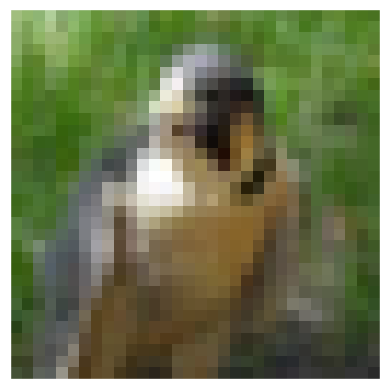

In [ ]:
def is_imperceptible_pixel(image_id,start_x,start_y):
  # image_id=384
  img=x_test[image_id]
  model=resnet
  x=start_x
  y=start_y
  r=img[x][y][0]
  g=img[x][y][1]
  b=img[x][y][2]

  rgb_list=[(r+20,g,b),(r,g+20,b),(r,g,b+20),(r+20,g+20,b),(r+20,g,b+20),(r,g+20,b+20),(r+20,g+20,b+20)]
  for i in rgb_list:
    show_attacked_image(image_id,x,y,i)


is_imperceptible_pixel(384,16,17)




x:16,y:19,rgb:(118, 96, 49)
1/1 [==============================] - 0s 52ms/step
confidence : 0.706617534160614
1/1 [==============================] - 0s 49ms/step
0.7103075
0.7039991
0.006308377
1/1 [==============================] - 0s 48ms/step
diff_b:-0.00027185678482055664
v_b:-0.00027185678482055664
b+v_b:0.7037272453308105
r:117,g:96,b:0
diff_r:0.006308376789093018,diff_g:-0.0044893622398376465,diff_b:-0.00027185678482055664
x:16,y:19,rgb:(117, 96, 0)
1/1 [==============================] - 0s 61ms/step
confidence : 0.6654812693595886
1/1 [==============================] - 0s 52ms/step
0.669622
0.66178805
0.007833958
1/1 [==============================] - 0s 35ms/step
diff_b:-1.8715858459472656e-05
v_b:-0.00010027289390563965
b+v_b:0.6616877734661102
r:116,g:96,b:0
diff_r:0.00783395767211914,diff_g:-0.004087626934051514,diff_b:-1.8715858459472656e-05
x:16,y:19,rgb:(116, 96, 0)
1/1 [==============================] - 0s 46ms/step
confidence : 0.6617880463600159
1/1 [================

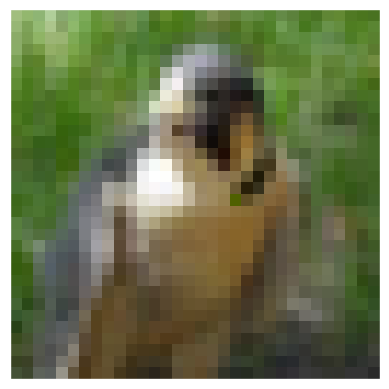

1/1 [==============================] - 0s 32ms/step
start_node:0.706617534160614,last_node:0.539341926574707,confidence_diff:0.16727560758590698


(79, 96, 0)

In [ ]:
def momentum(image_id,start_x,start_y):
  img=x_test[image_id]
  model=resnet
  x=start_x
  y=start_y
  r=img[x][y][0]
  g=img[x][y][1]
  b=img[x][y][2]
  start_r=r
  start_g=g
  start_b=b
  # print(y_test[image_id,:])
  true_class = y_test[image_id, 0]

  rate=1
  momentum_rate=0.3

  v_r=0
  v_g=0
  v_b=0
  rgb_list=[]
  last_rgb=()

  for i in range(50):
    node=np.array([x,y,r,g,b])
    print(f"x:{x},y:{y},rgb:{r,g,b}")
    print(f"confidence : {model.predict_one(perturb_image(node,img))[true_class]}")
    node_plus=np.array([x,y,bound(r+1),g,b])
    node_minus=np.array([x,y,bound(r-1),g,b])


    a=model.predict_one(perturb_image(node_plus,img))[true_class]
    b=model.predict_one(perturb_image(node_minus,img))[true_class]

    print(a)
    print(b)

    diff_r=a-b

    print(diff_r)

    diff_r=model.predict_one(perturb_image(node_plus,img))[true_class]-model.predict_one(perturb_image(node_minus,img))[true_class]

    node_plus=np.array([x,y,r,bound(g+1),b])
    node_minus=np.array([x,y,r,bound(g-1),b])

    diff_g=model.predict_one(perturb_image(node_plus,img))[true_class]-model.predict_one(perturb_image(node_minus,img))[true_class]

    node_plus=np.array([x,y,r,g,bound(b+1)])
    node_minus=np.array([x,y,r,g,bound(b-1)])

    diff_b=model.predict_one(perturb_image(node_plus,img))[true_class]-model.predict_one(perturb_image(node_minus,img))[true_class]
    print(f"diff_b:{diff_b}")
    v_r=momentum_rate*v_r+diff_r*rate
    v_g=momentum_rate*v_g+diff_g*rate
    v_b=momentum_rate*v_b+diff_b*rate
    print(f"v_b:{v_b}")

    new_r=bound(r-v_r)
    new_g=bound(g-v_g)
    new_b=bound(b-v_b)
    print(f"b+v_b:{b+v_b}")

    if(new_r==r and new_g==g and new_b==b):
      break
    r=new_r
    g=new_g
    b=new_b
    rgb_list.append((r,g,b))
    print(f"r:{r},g:{g},b:{b}")
    print(f"diff_r:{diff_r},diff_g:{diff_g},diff_b:{diff_b}")
  last_rgb=rgb_list[-1]
  rgb_list_per_ten=[]
  for i in range(len(rgb_list)):
      if i % 10 == 0 and i!=0:
          print(rgb_list_per_ten)
          rgb_list_per_ten = []  # 다음 10의 배수를 위해 리스트 초기화
      rgb_list_per_ten.append(rgb_list[i])

  # 마지막으로 남은 데이터를 출력 (10의 배수가 아닌 경우)
  if rgb_list_per_ten:
      print(rgb_list_per_ten)


  show_attacked_image(image_id,x,y,last_rgb)
  start_node=np.array([start_x,start_y,start_r,start_g,start_b])
  last_node=np.array([start_x,start_y,last_rgb[0],last_rgb[1],last_rgb[2]])
  confidence_diff=model.predict_one(x_test[image_id])[true_class]-model.predict_one(perturb_image(last_node,img))[true_class]
  print(f"start_node:{model.predict_one(x_test[image_id])[true_class]},last_node:{model.predict_one(perturb_image(last_node,img))[true_class]},confidence_diff:{confidence_diff}")
  return (r,g,b)


def bound(num):
  return int(max(0,min(255,num)))
img=x_test[384]
momentum(384,16,19)
#384

In [ ]:
def pixel_confidence(image_id):
    img_original = x_test[image_id].copy()


    img_confidence = x_test[image_id].copy()

    target_class = y_test[image_id, 0]

    helper.plot_image(img_original)

    model=lenet
    prior_confidence =  model.predict_one(img_original)[target_class]

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img_original)

          after_confidence =  model.predict_one(perturbed_image)[target_class]
          diff_confidence = abs(after_confidence - prior_confidence)

          img_confidence = perturb_image(np.array([x, y,  255 - diff_confidence * 255, 255 - diff_confidence * 255, 255 - diff_confidence * 255]), img_confidence)

    #       if diff_confidence > 0:
    #           for diff_index in range(len(diff_list)):
    #               if diff_confidence >= diff_list[diff_index][2]:
    #                   diff_list.insert(diff_index, [x, y, diff_confidence])
    #                   if (len(diff_list) > 30):
    #                       diff_list.pop()
    #                   break

    # for i in range(30):
    #     img_confidence = perturb_image(np.array([diff_list[i][0], diff_list[i][1],  (30- i) * 8.5, 0, 0]), img_confidence)
    print(diff_list)
    helper.plot_image(img_confidence)

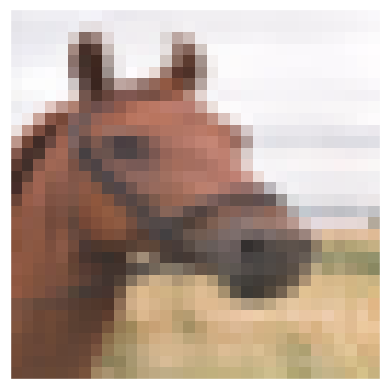

1/1 [==============================] - 0s 34ms/step
[[0, 0, 0]]


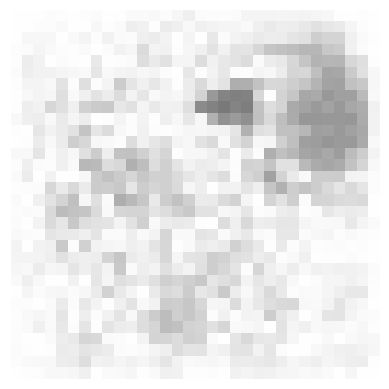

In [ ]:
pixel_confidence(99)

### beam search + momentum

[255, 16, 19, 118, 96, 49]
1/1 [==============================] - 0s 55ms/step
0.81582135
0.81281585
0.0030055046
1/1 [==============================] - 0s 37ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 36ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 32ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 33ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 34ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 34ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 35ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 33ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 32ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 34ms/step
0.9021984
0.9018708
0.00032758713
1/1 [=====================

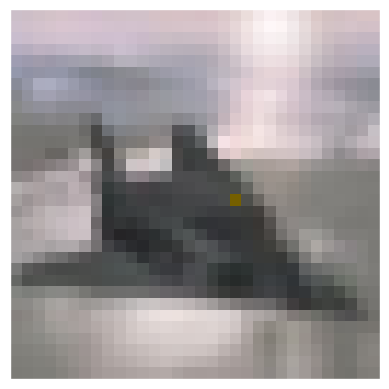

1/1 [==============================] - 0s 45ms/step
start_node:0.7173921465873718,last_node:0.9018461108207703,confidence_diff:-0.18445396423339844
score:[117.97297588659788, 95.80771283714152, 0.9031113301004682]
[255, 16, 19, 138, 96, 49]
1/1 [==============================] - 0s 69ms/step
0.8297634
0.82841474
0.0013486743
1/1 [==============================] - 0s 45ms/step
0.8702408
0.87813586
-0.007895052
1/1 [==============================] - 0s 47ms/step
0.86603904
0.8744105
-0.008371472
1/1 [==============================] - 0s 42ms/step
0.86603904
0.8744105
-0.008371472
1/1 [==============================] - 0s 42ms/step
0.86603904
0.8744105
-0.008371472
1/1 [==============================] - 0s 46ms/step
0.86603904
0.8744105
-0.008371472
1/1 [==============================] - 0s 43ms/step
0.86603904
0.8744105
-0.008371472
1/1 [==============================] - 0s 45ms/step
0.86603904
0.8744105
-0.008371472
1/1 [==============================] - 0s 59ms/step
0.86603904
0.874410

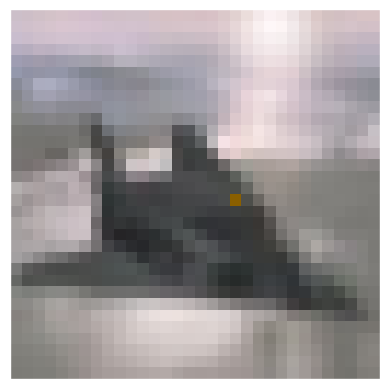

1/1 [==============================] - 0s 38ms/step
start_node:0.7173921465873718,last_node:0.8702408075332642,confidence_diff:-0.15284866094589233
score:[138.57827039640787, 95.99584227192155, 0.8745285272598267]
[255, 16, 19, 118, 116, 49]
1/1 [==============================] - 0s 32ms/step
0.887968
0.8888306
-0.0008625984
1/1 [==============================] - 0s 36ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 57ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 47ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 34ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 40ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 34ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 36ms/step
0.9103103
0.91154087
-0.0012305379
1/1 [==============================] - 0s 38ms/step
0.9103103
0.

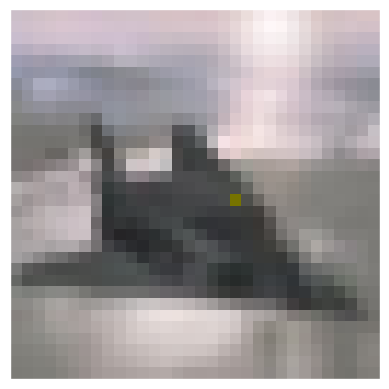

1/1 [==============================] - 0s 37ms/step
start_node:0.7173921465873718,last_node:0.9110181927680969,confidence_diff:-0.1936260461807251
score:[118.0866165453075, 115.96549566181324, 0.9120148931230817]
[255, 16, 19, 118, 96, 69]
1/1 [==============================] - 0s 33ms/step
0.7708936
0.77134335
-0.00044977665
1/1 [==============================] - 0s 42ms/step
0.90240353
0.9018461
0.00055742264
1/1 [==============================] - 0s 34ms/step
0.90240353
0.9018461
0.00055742264
1/1 [==============================] - 0s 30ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 35ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 38ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 35ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 34ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 41ms/step
0.9021984
0.9018

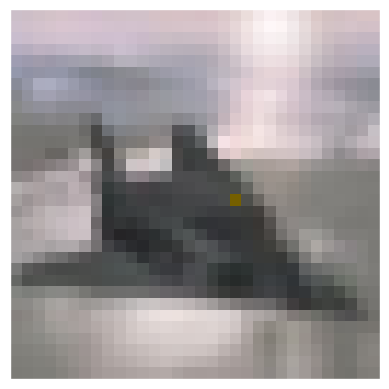

1/1 [==============================] - 0s 32ms/step
start_node:0.7173921465873718,last_node:0.9018461108207703,confidence_diff:-0.18445396423339844
score:[117.97725532979376, 95.80844324948855, 0.9031113301004682]
[255, 16, 19, 98, 96, 49]
1/1 [==============================] - 0s 35ms/step
0.83331996
0.8353311
-0.0020111203
1/1 [==============================] - 0s 35ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 37ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 33ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 77ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 50ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 59ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 33ms/step
0.90823007
0.9079483
0.00028175116
1/1 [==============================] - 0s 39ms/step
0.90823007
0

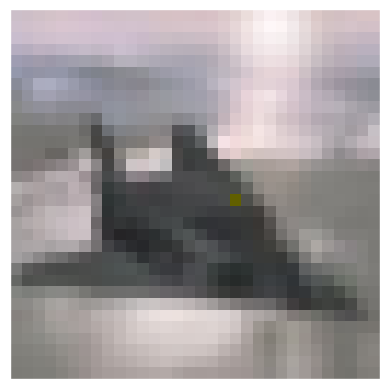

1/1 [==============================] - 0s 50ms/step
start_node:0.7173921465873718,last_node:0.9079483151435852,confidence_diff:-0.19055616855621338
score:[97.94768146349452, 95.69451028473532, 0.9094141295978001]
[255, 16, 19, 118, 76, 49]
1/1 [==============================] - 0s 54ms/step
0.77696323
0.7678767
0.009086549
1/1 [==============================] - 0s 34ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 36ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 32ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 34ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 33ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 31ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 33ms/step
0.8730677
0.87172836
0.0013393164
1/1 [==============================] - 0s 32ms/step
0.8730677
0.87172836


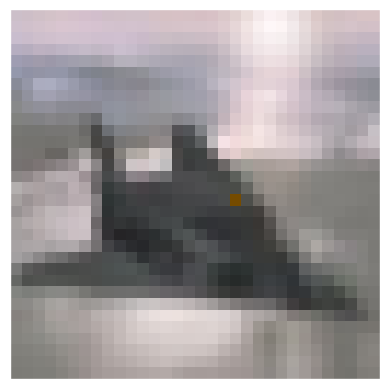

1/1 [==============================] - 0s 40ms/step
start_node:0.7173921465873718,last_node:0.8721190690994263,confidence_diff:-0.15472692251205444
score:[117.89408705915724, 75.87846891490797, 0.8720939074243818]
[255, 16, 19, 118, 96, 29]
1/1 [==============================] - 0s 32ms/step
0.86785066
0.8655624
0.002288282
1/1 [==============================] - 0s 36ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 37ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 34ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 32ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 50ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 47ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 58ms/step
0.9021984
0.9018708
0.00032758713
1/1 [==============================] - 0s 33ms/step
0.9021984
0.9018708


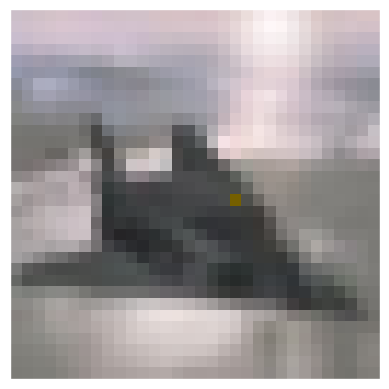

1/1 [==============================] - 0s 58ms/step
start_node:0.7173921465873718,last_node:0.9018461108207703,confidence_diff:-0.18445396423339844
score:[117.9740004904416, 95.80771283714152, 0.9031113301004682]
[255, 16, 19, 0, 255, 0]
1/1 [==============================] - 0s 48ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 53ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 53ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 34ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 31ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 31ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 34ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 31ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 32ms/step
0.9082037
0.90

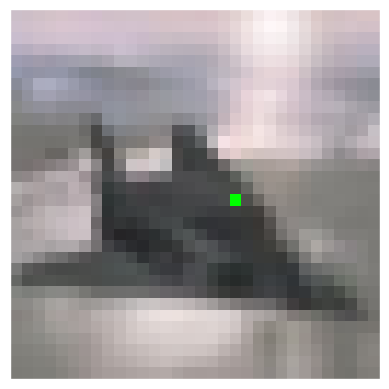

1/1 [==============================] - 0s 32ms/step
start_node:0.7173921465873718,last_node:0.9083164930343628,confidence_diff:-0.19092434644699097
score:[0.007986097919697665, 255, 0.9098323243004935]
[255, 16, 19, 20, 255, 0]
1/1 [==============================] - 0s 33ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 31ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 37ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 33ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 32ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 38ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 52ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 55ms/step
0.90648466
0.90668464
-0.00019997358
1/1 [==============================] - 0s 33ms/step
0.906484

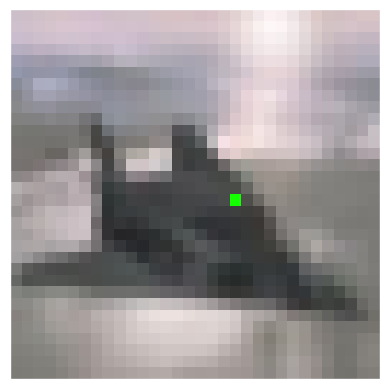

1/1 [==============================] - 0s 48ms/step
start_node:0.7173921465873718,last_node:0.9065821170806885,confidence_diff:-0.18918997049331665
score:[20.014161394566926, 255, 0.9081050157546997]
[255, 16, 19, 0, 255, 0]
1/1 [==============================] - 0s 48ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 44ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 32ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 35ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 36ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 34ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 34ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 38ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 35ms/step
0.9082037
0.9083165
-0.0001

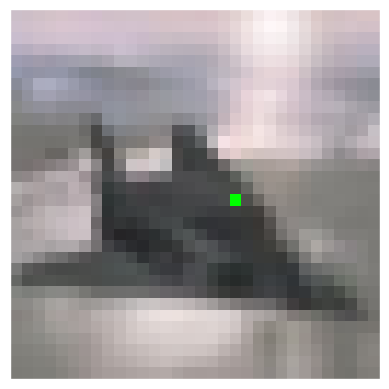

1/1 [==============================] - 0s 46ms/step
start_node:0.7173921465873718,last_node:0.9083164930343628,confidence_diff:-0.19092434644699097
score:[0.007986097919697665, 255, 0.9098323243004935]
[255, 16, 19, 0, 255, 20]
1/1 [==============================] - 0s 43ms/step
0.8869843
0.8867706
0.00021368265
1/1 [==============================] - 0s 44ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 43ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 61ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 64ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 44ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 42ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 46ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 49ms/step
0.9082037
0.9083165
-0.00

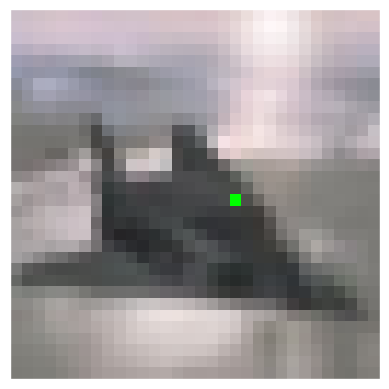

1/1 [==============================] - 0s 31ms/step
start_node:0.7173921465873718,last_node:0.9083164930343628,confidence_diff:-0.19092434644699097
score:[0.00773341680059628, 255, 0.9098323243004935]
[255, 16, 19, 0, 255, 0]
1/1 [==============================] - 0s 37ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 31ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 32ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 36ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 33ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 34ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 31ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 32ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 37ms/step
0.9082037
0.9083165
-0.000

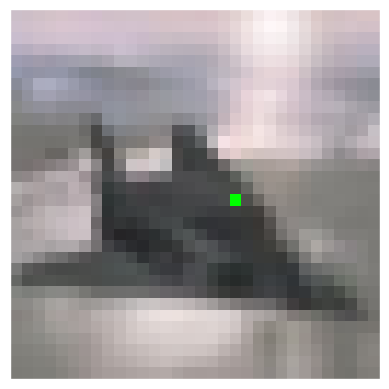

1/1 [==============================] - 0s 33ms/step
start_node:0.7173921465873718,last_node:0.9083164930343628,confidence_diff:-0.19092434644699097
score:[0.007986097919697665, 255, 0.9098323243004935]
[255, 16, 19, 0, 235, 0]
1/1 [==============================] - 0s 34ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 34ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 33ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 51ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 32ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 34ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 31ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 34ms/step
0.91772825
0.91796225
-0.00023400784
1/1 [==============================] - 0s 42ms/step
0.9177282

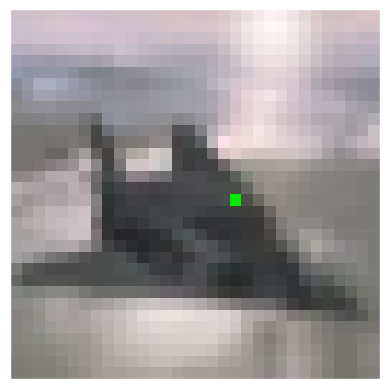

1/1 [==============================] - 0s 38ms/step
start_node:0.7173921465873718,last_node:0.9179622530937195,confidence_diff:-0.20057010650634766
score:[0.016571575281571358, 235.04632105632692, 0.9193059120859418]
[255, 16, 19, 0, 255, 0]
1/1 [==============================] - 0s 33ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 36ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 37ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 40ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 38ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 35ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 48ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 53ms/step
0.9082037
0.9083165
-0.00011277199
1/1 [==============================] - 0s 34ms/step
0.9082037


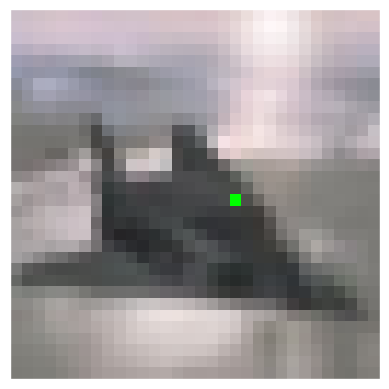

1/1 [==============================] - 0s 31ms/step
start_node:0.7173921465873718,last_node:0.9083164930343628,confidence_diff:-0.19092434644699097
score:[0.007986097919697665, 255, 0.9098323243004935]
[255, 16, 19, 0, 0, 0]
1/1 [==============================] - 0s 32ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 35ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 36ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 35ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 38ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 34ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 33ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 35ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 36ms/step
0.9727692
0.9729952
-0.0002

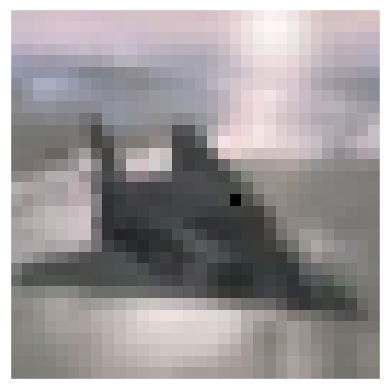

1/1 [==============================] - 0s 57ms/step
start_node:0.7173921465873718,last_node:0.9729952216148376,confidence_diff:-0.2556030750274658
score:[0.016005963695292582, 0, 0.9729210564068386]
[255, 16, 19, 20, 0, 0]
1/1 [==============================] - 0s 51ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 54ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 38ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 36ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 31ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 32ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 33ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 32ms/step
0.9604114
0.9616473
-0.0012358427
1/1 [==============================] - 0s 40ms/step
0.9604114
0.9616473
-0.0012358427
1/1

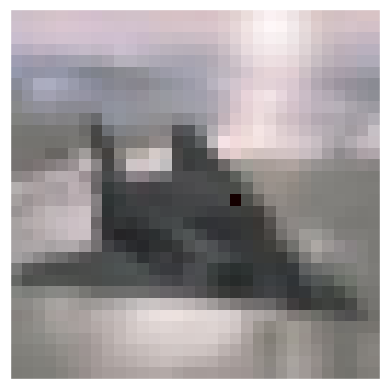

1/1 [==============================] - 0s 35ms/step
start_node:0.7173921465873718,last_node:0.9610329866409302,confidence_diff:-0.24364084005355835
score:[20.087517840521674, 0.02148057733263288, 0.9612747430801392]
[255, 16, 19, 0, 20, 0]
1/1 [==============================] - 0s 37ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 33ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 32ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 34ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 33ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 32ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 48ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 57ms/step
0.96374923
0.9643142
-0.0005649924
1/1 [==============================] - 0s 35ms/step
0.96374923
0

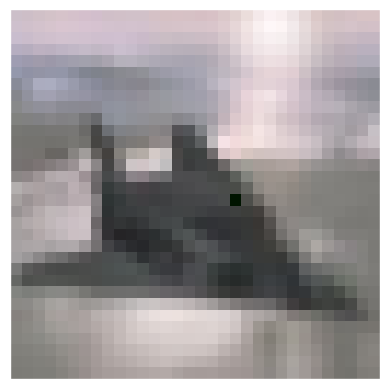

1/1 [==============================] - 0s 33ms/step
start_node:0.7173921465873718,last_node:0.9643142223358154,confidence_diff:-0.2469220757484436
score:[0.040010688256244244, 20.103473152433118, 0.9640999010631016]
[255, 16, 19, 0, 0, 20]
1/1 [==============================] - 0s 34ms/step
0.974445
0.9744509
-5.90086e-06
1/1 [==============================] - 0s 35ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 37ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 33ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 31ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 35ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 37ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 31ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 31ms/step
0.9727692
0.972

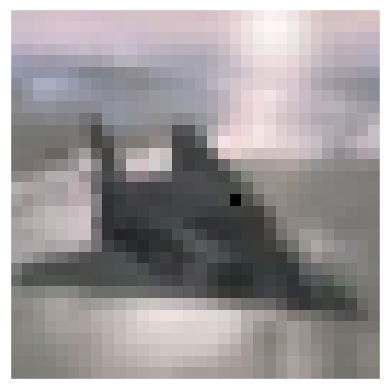

1/1 [==============================] - 0s 46ms/step
start_node:0.7173921465873718,last_node:0.9729952216148376,confidence_diff:-0.2556030750274658
score:[0.01569150661935613, 0, 0.9729210564068386]
[255, 16, 19, 0, 0, 0]
1/1 [==============================] - 0s 46ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 52ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 36ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 34ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 32ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 42ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 39ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 31ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 31ms/step
0.9727692
0.9729952
-0.00022602

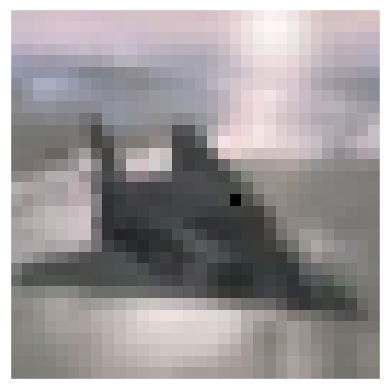

1/1 [==============================] - 0s 41ms/step
start_node:0.7173921465873718,last_node:0.9729952216148376,confidence_diff:-0.2556030750274658
score:[0.016005963695292582, 0, 0.9729210564068386]
[255, 16, 19, 0, 0, 0]
1/1 [==============================] - 0s 45ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 42ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 46ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 45ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 74ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 61ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 46ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 48ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 40ms/step
0.9727692
0.9729952
-0.0002260

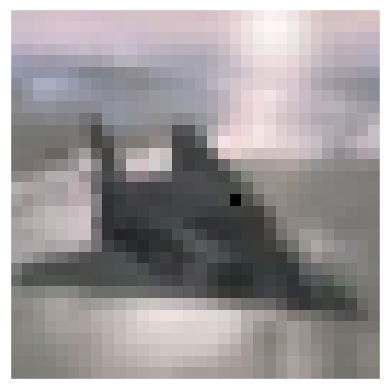

1/1 [==============================] - 0s 33ms/step
start_node:0.7173921465873718,last_node:0.9729952216148376,confidence_diff:-0.2556030750274658
score:[0.016005963695292582, 0, 0.9729210564068386]
[255, 16, 19, 0, 0, 0]
1/1 [==============================] - 0s 34ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 32ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 42ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 30ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 36ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 43ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 30ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 35ms/step
0.9727692
0.9729952
-0.00022602081
1/1 [==============================] - 0s 34ms/step
0.9727692
0.9729952
-0.0002260

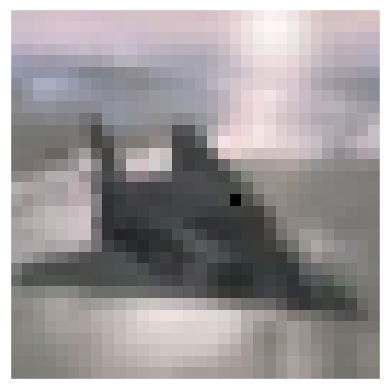

1/1 [==============================] - 0s 34ms/step
start_node:0.7173921465873718,last_node:0.9729952216148376,confidence_diff:-0.2556030750274658
score:[0.016005963695292582, 0, 0.9729210564068386]
[255, 16, 19, 255, 255, 255]
1/1 [==============================] - 0s 36ms/step
0.9865463
0.986484
6.2286854e-05
1/1 [==============================] - 0s 35ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 50ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 47ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 39ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 39ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 41ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==

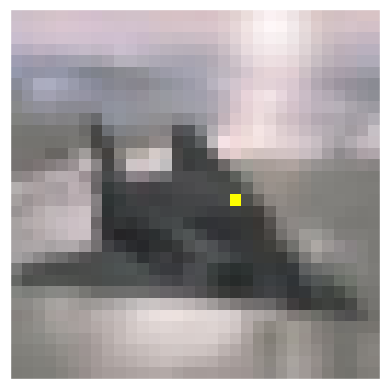

1/1 [==============================] - 0s 32ms/step
start_node:0.7173921465873718,last_node:0.9066476821899414,confidence_diff:-0.18925553560256958
score:[254.96153462906247, 254.85208592852732, 0.9053798317909241]
[255, 16, 19, 255, 255, 255]
1/1 [==============================] - 0s 34ms/step
0.9865463
0.986484
6.2286854e-05
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 39ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 35ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 34ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 66ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 32ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 32ms/step
0.9068997
0.9063466
0.00

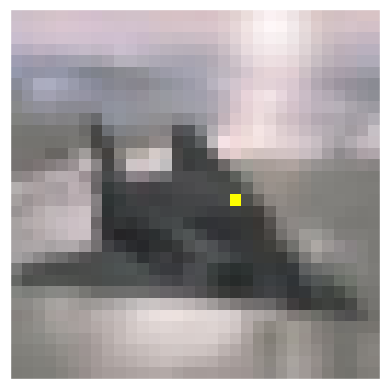

1/1 [==============================] - 0s 32ms/step
start_node:0.7173921465873718,last_node:0.9066476821899414,confidence_diff:-0.18925553560256958
score:[254.96153462906247, 254.85208592852732, 0.9053798317909241]
[255, 16, 19, 255, 255, 255]
1/1 [==============================] - 0s 38ms/step
0.9865463
0.986484
6.2286854e-05
1/1 [==============================] - 0s 32ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 40ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 43ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 34ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 43ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 56ms/step
0.9068997
0.9063466
0.00

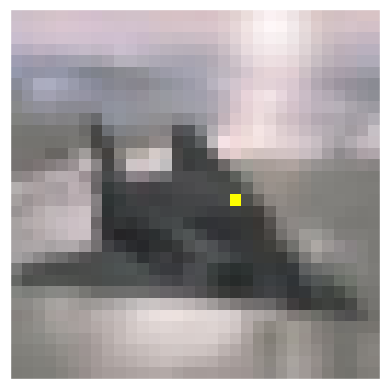

1/1 [==============================] - 0s 36ms/step
start_node:0.7173921465873718,last_node:0.9066476821899414,confidence_diff:-0.18925553560256958
score:[254.96153462906247, 254.85208592852732, 0.9053798317909241]
[255, 16, 19, 255, 255, 255]
1/1 [==============================] - 0s 33ms/step
0.9865463
0.986484
6.2286854e-05
1/1 [==============================] - 0s 32ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 34ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 34ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 38ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 33ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 32ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 31ms/step
0.9068997
0.9063466
0.00

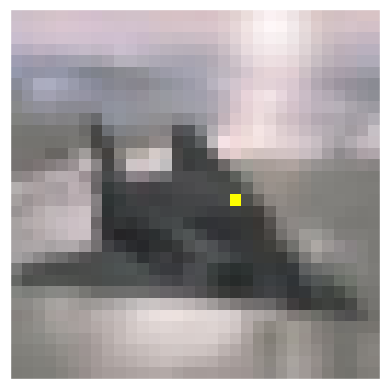

1/1 [==============================] - 0s 34ms/step
start_node:0.7173921465873718,last_node:0.9066476821899414,confidence_diff:-0.18925553560256958
score:[254.96153462906247, 254.85208592852732, 0.9053798317909241]
[255, 16, 19, 235, 255, 255]
1/1 [==============================] - 0s 38ms/step
0.9852297
0.9849939
0.00023579597
1/1 [==============================] - 0s 54ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 59ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 33ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 35ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 35ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 33ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 34ms/step
0.90437233
0.9040987
0.00027364492
1/1 [==============================] - 0s 36ms/step
0.9043723

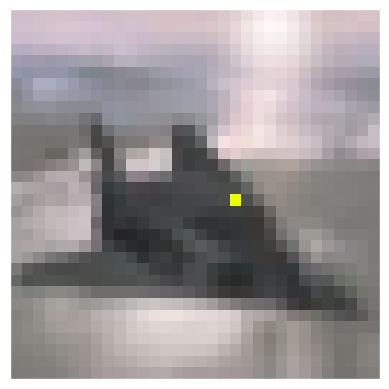

1/1 [==============================] - 0s 46ms/step
start_node:0.7173921465873718,last_node:0.9041905403137207,confidence_diff:-0.18679839372634888
score:[234.98067554162435, 254.88037223718635, 0.9028474177633014]
[255, 16, 19, 255, 235, 255]
1/1 [==============================] - 0s 44ms/step
0.9858095
0.98572636
8.314848e-05
1/1 [==============================] - 0s 52ms/step
0.8835383
0.88356245
-2.4139881e-05
1/1 [==============================] - 0s 49ms/step
0.8835383
0.88356245
-2.4139881e-05
1/1 [==============================] - 0s 45ms/step
0.8835383
0.88356245
-2.4139881e-05
1/1 [==============================] - 0s 61ms/step
0.8835383
0.88356245
-2.4139881e-05
1/1 [==============================] - 0s 45ms/step
0.8835383
0.88347906
5.9247017e-05
1/1 [==============================] - 0s 45ms/step
0.8835383
0.88356245
-2.4139881e-05
1/1 [==============================] - 0s 42ms/step
0.8835383
0.88356245
-2.4139881e-05
1/1 [==============================] - 0s 42ms/step
0.8

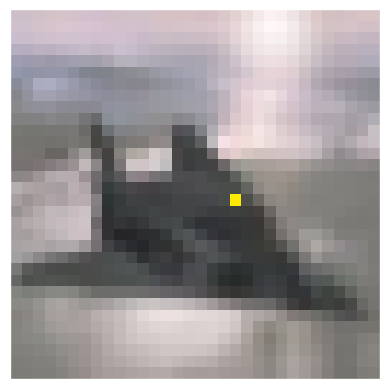

1/1 [==============================] - 0s 41ms/step
start_node:0.7173921465873718,last_node:0.8834790587425232,confidence_diff:-0.16608691215515137
score:[254.99995041769688, 234.79517342714365, 0.8826097517691861]
[255, 16, 19, 255, 255, 235]
1/1 [==============================] - 0s 33ms/step
0.9860169
0.9859533
6.365776e-05
1/1 [==============================] - 0s 42ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 36ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 32ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 42ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 52ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 53ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 42ms/step
0.9068997
0.9063466
0.0005530715
1/1 [==============================] - 0s 34ms/step
0.9068997
0.9063466
0.00

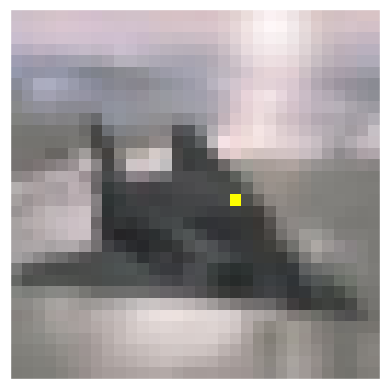

1/1 [==============================] - 0s 36ms/step
start_node:0.7173921465873718,last_node:0.9066476821899414,confidence_diff:-0.18925553560256958
score:[254.96153267062417, 254.85208592852732, 0.9053798317909241]
[255, 16, 19, 255, 0, 0]
1/1 [==============================] - 0s 32ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 43ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 36ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 38ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 37ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 41ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 58ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 56ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 34ms/step
0.9022673
0.

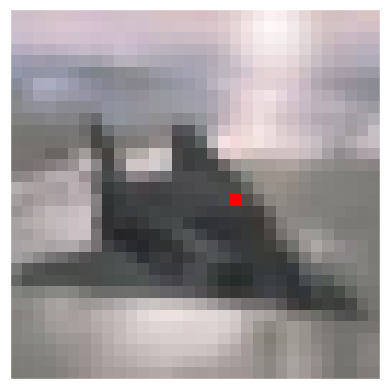

1/1 [==============================] - 0s 43ms/step
start_node:0.7173921465873718,last_node:0.9022672772407532,confidence_diff:-0.18487513065338135
score:[255, 0, 0.9013031550816127]
[255, 16, 19, 255, 0, 0]
1/1 [==============================] - 0s 35ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 36ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 46ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 52ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 56ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 33ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 35ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 37ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 43ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [====

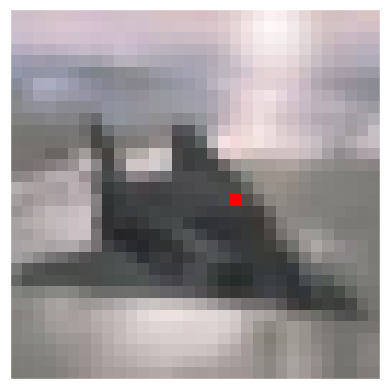

1/1 [==============================] - 0s 37ms/step
start_node:0.7173921465873718,last_node:0.9022672772407532,confidence_diff:-0.18487513065338135
score:[255, 0, 0.9013031550816127]
[255, 16, 19, 255, 20, 0]
1/1 [==============================] - 0s 36ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 35ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 34ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 35ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 48ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 53ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 34ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 38ms/step
0.89540994
0.89570415
-0.00029420853
1/1 [==============================] - 0s 31ms/step
0.89540994
0.89570415
-0.00

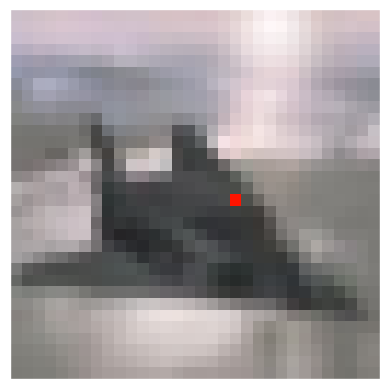

1/1 [==============================] - 0s 32ms/step
start_node:0.7173921465873718,last_node:0.8954099416732788,confidence_diff:-0.17801779508590698
score:[255, 20.082254275983733, 0.895356399672372]
[255, 16, 19, 255, 0, 20]
1/1 [==============================] - 0s 32ms/step
0.9083163
0.9084588
-0.0001425147
1/1 [==============================] - 0s 36ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 51ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 54ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 37ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 35ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 36ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 32ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 44ms/step
0.9022673
0.9022738
-6.49690

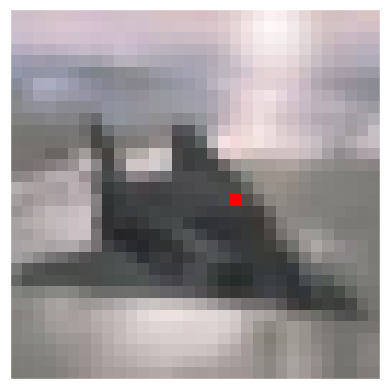

1/1 [==============================] - 0s 31ms/step
start_node:0.7173921465873718,last_node:0.9022672772407532,confidence_diff:-0.18487513065338135
score:[255, 0, 0.9013031550816127]
[255, 16, 19, 235, 0, 0]
1/1 [==============================] - 0s 32ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 34ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 36ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 67ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 56ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 33ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 31ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 32ms/step
0.90785867
0.90835625
-0.0004975796
1/1 [==============================] - 0s 34ms/step
0.90785867
0.90835625
-0.0004975796


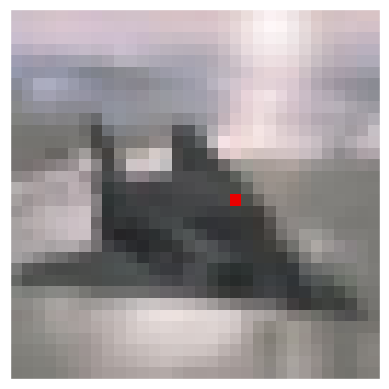

1/1 [==============================] - 0s 36ms/step
start_node:0.7173921465873718,last_node:0.9081329107284546,confidence_diff:-0.19074076414108276
score:[235.03523675762895, 0.040555194932587295, 0.9080331070082528]
[255, 16, 19, 255, 0, 0]
1/1 [==============================] - 0s 44ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 34ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 52ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 50ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 41ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 36ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 37ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 34ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 34ms/step
0.9022673


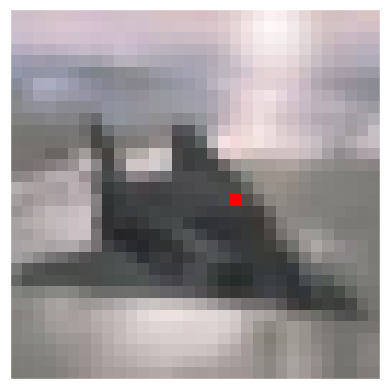

1/1 [==============================] - 0s 35ms/step
start_node:0.7173921465873718,last_node:0.9022672772407532,confidence_diff:-0.18487513065338135
score:[255, 0, 0.9013031550816127]
[255, 16, 19, 255, 0, 0]
1/1 [==============================] - 0s 34ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 41ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 32ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 39ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 47ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 52ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 32ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 33ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [==============================] - 0s 35ms/step
0.9022673
0.9022738
-6.4969063e-06
1/1 [====

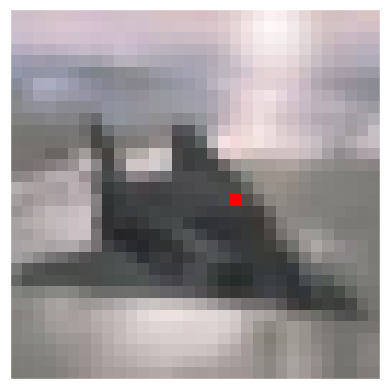

1/1 [==============================] - 0s 32ms/step
start_node:0.7173921465873718,last_node:0.9022672772407532,confidence_diff:-0.18487513065338135
score:[255, 0, 0.9013031550816127]


TypeError: ignored

In [ ]:
def momentum_for_beam_search(image_id,start_x,start_y,r,g,b):
  img=x_test[image_id]
  model=resnet
  x=start_x
  y=start_y
  # r=img[x][y][0]
  # g=img[x][y][1]
  # b=img[x][y][2]
  start_r=r
  start_g=g
  start_b=b
  # print(y_test[image_id,:])
  true_class = y_test[image_id, 0]

  rate=1
  momentum_rate=0.3

  v_r=0
  v_g=0
  v_b=0
  rgb_list=[]
  last_rgb=()

  for i in range(50):
    node=np.array([x,y,r,g,b])
    # print(f"x:{x},y:{y},rgb:{r,g,b}")
    # print(f"confidence : {model.predict_one(perturb_image(node,img))[true_class]}")
    node_plus=np.array([x,y,bound(r+1),g,b])
    node_minus=np.array([x,y,bound(r-1),g,b])


    a=model.predict_one(perturb_image(node_plus,img))[true_class]
    b=model.predict_one(perturb_image(node_minus,img))[true_class]

    print(a)
    print(b)

    diff_r=a-b

    print(diff_r)

    diff_r=model.predict_one(perturb_image(node_plus,img))[true_class]-model.predict_one(perturb_image(node_minus,img))[true_class]

    node_plus=np.array([x,y,r,bound(g+1),b])
    node_minus=np.array([x,y,r,bound(g-1),b])

    diff_g=model.predict_one(perturb_image(node_plus,img))[true_class]-model.predict_one(perturb_image(node_minus,img))[true_class]

    node_plus=np.array([x,y,r,g,bound(b+1)])
    node_minus=np.array([x,y,r,g,bound(b-1)])

    diff_b=model.predict_one(perturb_image(node_plus,img))[true_class]-model.predict_one(perturb_image(node_minus,img))[true_class]
    # print(f"diff_b:{diff_b}")
    v_r=momentum_rate*v_r+diff_r*rate
    v_g=momentum_rate*v_g+diff_g*rate
    v_b=momentum_rate*v_b+diff_b*rate
    # print(f"v_b:{v_b}")

    new_r=bound(r-v_r)
    new_g=bound(g-v_g)
    new_b=bound(b-v_b)
    # print(f"b+v_b:{b+v_b}")

    if(new_r==r and new_g==g and new_b==b):
      break
    r=new_r
    g=new_g
    b=new_b
    rgb_list.append([r,g,b])
    # print(f"r:{r},g:{g},b:{b}")
    # print(f"diff_r:{diff_r},diff_g:{diff_g},diff_b:{diff_b}")
  last_rgb=rgb_list[-1]
  rgb_list_per_ten=[]
  for i in range(len(rgb_list)):
      if i % 10 == 0 and i!=0:
          print(rgb_list_per_ten)
          rgb_list_per_ten = []  # 다음 10의 배수를 위해 리스트 초기화
      rgb_list_per_ten.append(rgb_list[i])

  # 마지막으로 남은 데이터를 출력 (10의 배수가 아닌 경우)
  if rgb_list_per_ten:
      print(rgb_list_per_ten)


  show_attacked_image(image_id,x,y,last_rgb)
  start_node=np.array([start_x,start_y,start_r,start_g,start_b])
  last_node=np.array([start_x,start_y,last_rgb[0],last_rgb[1],last_rgb[2]])
  confidence_diff=model.predict_one(x_test[image_id])[true_class]-model.predict_one(perturb_image(last_node,img))[true_class]
  print(f"start_node:{model.predict_one(x_test[image_id])[true_class]},last_node:{model.predict_one(perturb_image(last_node,img))[true_class]},confidence_diff:{confidence_diff}")
  return [r,g,b]


def bound(x):
  if x>255 :
    return 255
  if x<0 :
    return 0
  else :
    return x

def beam_search_of_confidence(predictions,k):
  #[list_of_pixel,score]
  # sequences = [[list(),0]]
  sequences=predictions
  for i in range(5):
    all_candidates = [[list(),0]]
    for sequence in sequences:
      change_rgb_list=[[0,0,0,0,0,0],[0,0,0,20,0,0],[0,0,0,0,20,0],[0,0,0,0,0,20],[0,0,0,-20,0,0],[0,0,0,0,-20,0,0],[0,0,0,0,0,-20]]
      #1. 각각의 timestep에서 가능한 후보군으로 확장
      for change_rgb in change_rgb_list:
        new_pixel = [bound(x + y) for x, y in zip(sequence, change_rgb)]
        print(new_pixel)
        score=momentum_for_beam_search(new_pixel[0],new_pixel[1],new_pixel[2],new_pixel[3],new_pixel[4],new_pixel[5])
        print(f"score:{score}")
        all_candidates.append([new_pixel,score])
    #정렬해서 top5개만 sequences에 담기게 재할당
    sorted_data = sorted(all_candidates, key=lambda x: x[1], reverse=True)
    # 상위 5개 요소만 추출
    top_5 = sorted_data[:5]
    # 결과 출력
    print("top5")
    print(top_5)



predictions=[[384,16,19,118,96,49],[384,16,19,0,255,0],[384,16,19,0,0,0],[384,16,19,255,255,255],[384,16,19,255,0,0]]
beam_search_of_confidence(predictions,4)



In [ ]:
import numpy as np
def log(number):
  # log에 0이 들어가는 것을 막기 위해 아주 작은 수를 더해줌.
  return np.log(number + 1e-10)

def naive_beam_search_decoder(predictions, k):
  # prediction = (seq_len , V)
  sequences = [[list(), 1.0]]
  print(f"sequences:{sequences}")

  for row in predictions:
    all_candidates = list()

    # 1. 각각의 timestep에서 가능한 후보군으로 확장
    for i in range(len(sequences)):
      seq, score = sequences[i]
      print(f"sequences[{i}] = seq : {seq} , score : {score}")
      print(f"len(sequences):{len(sequences)}")
      # 2. 확장된 후보 스텝에 대해 점수 계산
      print(f"len(row):{len(row)}")
      for j in range(len(row)):
        new_seq = seq + [j]
        new_score = score * -log(row[j])
        candidate = [new_seq, new_score]
        all_candidates.append(candidate)
      print(f"all_candidates:{all_candidates}")
	# 3. 가능도가 높은 k개의 시퀀스만 남김
    ordered = sorted(all_candidates, key=lambda tup:tup[1]) #점수 기준 정렬
    sequences = ordered[:k]
    print(f"sequences = ordered[:k] : {sequences}")

  return sequences

import random
seq_len = 4
V = 10
predictions = [[random.random() for _ in range(V)] for _ in range(seq_len)]
print(predictions)
print(naive_beam_search_decoder(predictions,k=5))